# 📌 Extracción

In [1]:
#Importacion de librerias necesarias para el proyecto
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librerías para visualización
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [2]:
#  Cargar JSON
df = pd.read_json('TelecomX_Data.json')
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


# 🔧 Transformación

In [3]:
# Expandir cada columna anidada
customer_expanded = pd.json_normalize(df['customer'])
phone_expanded = pd.json_normalize(df['phone'])
internet_expanded = pd.json_normalize(df['internet'])
account_expanded = pd.json_normalize(df['account'])

# Combinar todo 
df_final = pd.concat([
    df[['customerID', 'Churn']],
    customer_expanded,
    phone_expanded,
    internet_expanded,
    account_expanded
], axis=1)

df_final.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [4]:
# Verificar si 'charges' está anidado y expandirlo
if 'charges' in df_final.columns:
    charges_expanded = pd.json_normalize(df_final['charges'])
    df_final = pd.concat([df_final.drop('charges', axis=1), charges_expanded], axis=1)
  

In [5]:
# ===PRUEBAS===

df_final['Churn'].unique()

array(['No', 'Yes', ''], dtype=object)

In [6]:
# Transformar sí/no 
for col in df_final.select_dtypes(include=['object']).columns:
    # Si veo que tiene 'Yes' o 'No' en los valores únicos
    valores = df_final[col].dropna().unique()
    tiene_yes_no = any(str(v) in ['Yes', 'No', 'yes', 'no'] for v in valores)
    
    if tiene_yes_no:
        df_final[col] = df_final[col].replace({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0})
        print(f"{col} → transformada")

df_final.head()


Churn → transformada
Partner → transformada
Dependents → transformada
PhoneService → transformada
MultipleLines → transformada
InternetService → transformada
OnlineSecurity → transformada
OnlineBackup → transformada
DeviceProtection → transformada
TechSupport → transformada
StreamingTV → transformada
StreamingMovies → transformada
PaperlessBilling → transformada


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,...,1,0,1,1,0,One year,1,Mailed check,65.6,593.3
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,...,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.4
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,...,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85
3,0011-IGKFF,1,Male,1,1,0,13,1,0,Fiber optic,...,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,Fiber optic,...,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.4


# 📊 Carga y análisis

In [7]:
print("🔍 IDENTIFICANDO VALORES NULOS:")
print("=" * 50)

# Contar valores nulos por columna
valores_nulos = df_final.isnull().sum()
valores_nulos_total = valores_nulos.sum()

print(f"Total de valores nulos en el DataFrame: {valores_nulos_total}")
print("\nValores nulos por columna:")
print("-" * 30)

🔍 IDENTIFICANDO VALORES NULOS:
Total de valores nulos en el DataFrame: 0

Valores nulos por columna:
------------------------------


In [8]:
#Crear cuentas diarias
df_final['Cuentas_Diarias'] = df_final['Charges.Monthly'] / 30

#Verificacion 
print("Cuentas_Diarias creada:")
print(df_final[['Charges.Monthly', 'Cuentas_Diarias']].head())



Cuentas_Diarias creada:
   Charges.Monthly  Cuentas_Diarias
0             65.6         2.186667
1             59.9         1.996667
2             73.9         2.463333
3             98.0         3.266667
4             83.9         2.796667


In [9]:
variables_numericas = df_final.select_dtypes(include=[np.number]).columns
descripcion = df_final[variables_numericas].describe()

print(descripcion)

       SeniorCitizen      Partner   Dependents       tenure  PhoneService  \
count    7267.000000  7267.000000  7267.000000  7267.000000   7267.000000   
mean        0.162653     0.484106     0.300124    32.346498      0.902711   
std         0.369074     0.499782     0.458343    24.571773      0.296371   
min         0.000000     0.000000     0.000000     0.000000      0.000000   
25%         0.000000     0.000000     0.000000     9.000000      1.000000   
50%         0.000000     0.000000     0.000000    29.000000      1.000000   
75%         0.000000     1.000000     1.000000    55.000000      1.000000   
max         1.000000     1.000000     1.000000    72.000000      1.000000   

       PaperlessBilling  Charges.Monthly  Cuentas_Diarias  
count       7267.000000      7267.000000      7267.000000  
mean           0.593230        64.720098         2.157337  
std            0.491265        30.129572         1.004319  
min            0.000000        18.250000         0.608333  
25%   

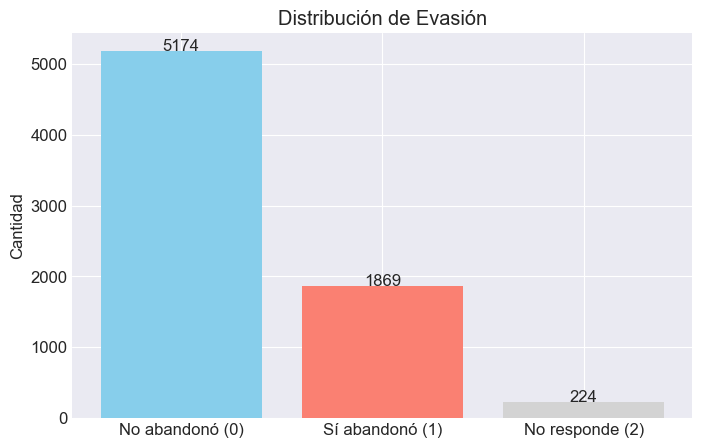

In [10]:
# En una línea: vacíos = 2
df_final['Churn'] = df_final['Churn'].replace('', 2).fillna(2).astype(int)

# Gráfico con leyenda
conteo = df_final['Churn'].value_counts()

plt.figure(figsize=(8, 5))
colores = ['skyblue', 'salmon', 'lightgray']
nombres = ['No abandonó (0)', 'Sí abandonó (1)', 'No responde (2)']

bars = plt.bar(nombres, [conteo.get(0,0), conteo.get(1,0), conteo.get(2,0)], color=colores)
plt.title('Distribución de Evasión')
plt.ylabel('Cantidad')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(int(height)), ha='center')

plt.show()


gender:
--------------------
gender
Female    0.319
Male      0.318
Name: Churn, dtype: float64


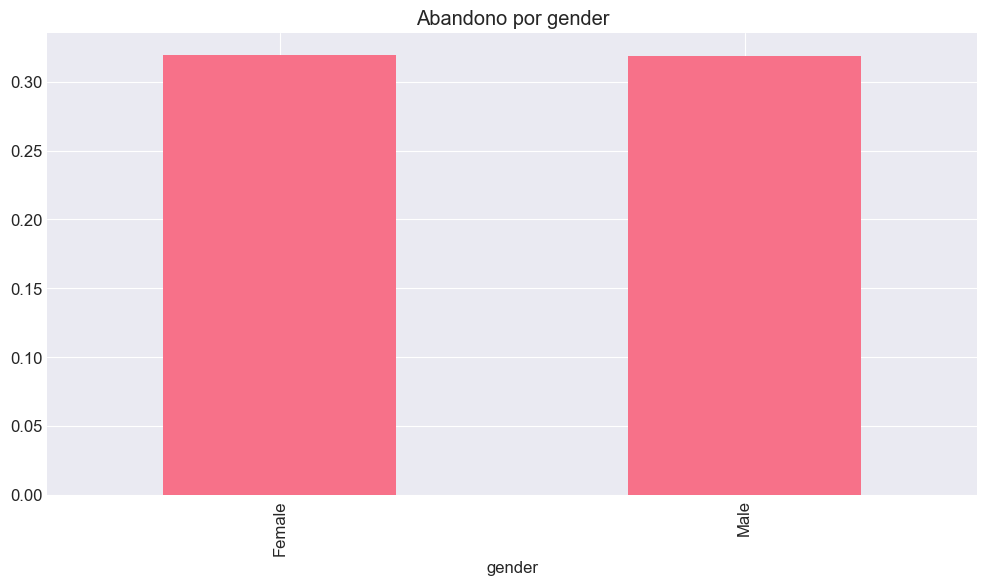


Contract:
--------------------
Contract
Month-to-month    0.478
One year          0.170
Two year          0.083
Name: Churn, dtype: float64


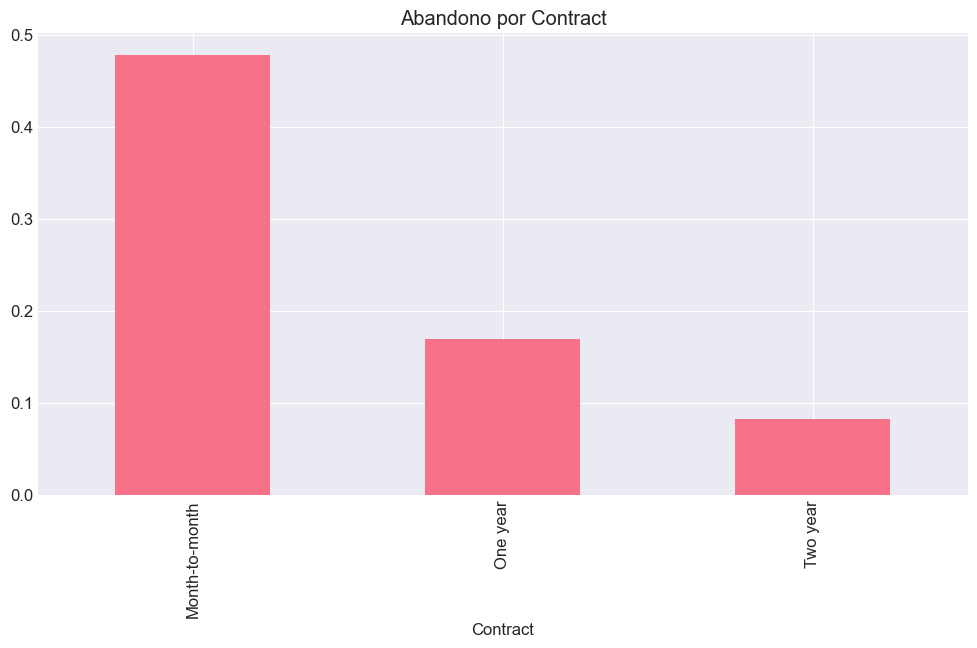


PaymentMethod:
--------------------
PaymentMethod
Bank transfer (automatic)    0.219
Credit card (automatic)      0.207
Electronic check             0.503
Mailed check                 0.249
Name: Churn, dtype: float64


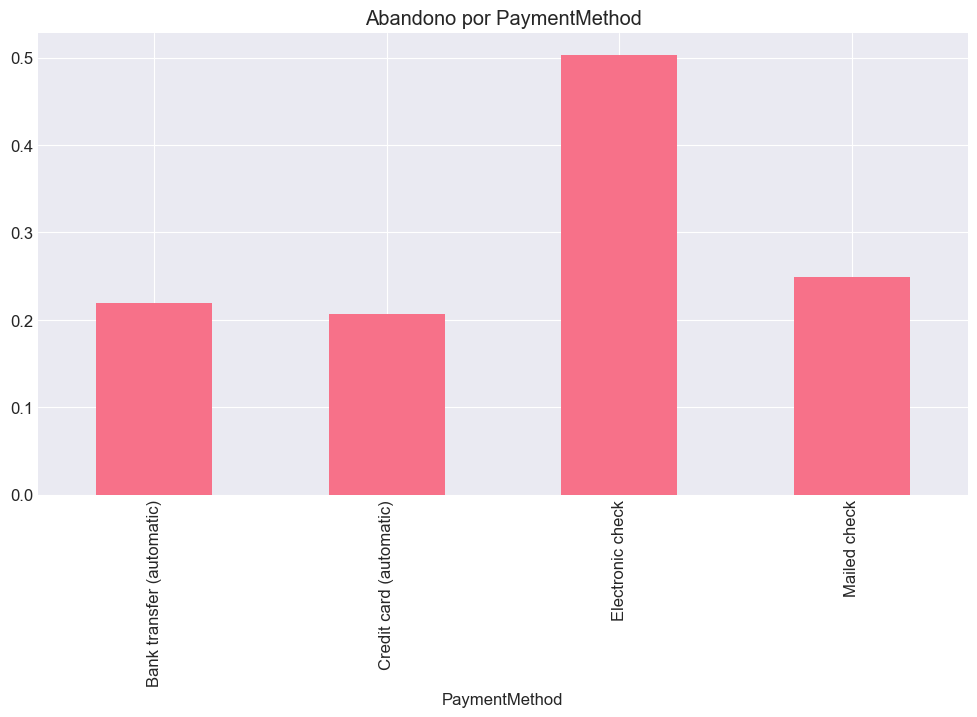


InternetService:
--------------------
InternetService
0              0.141
DSL            0.238
Fiber optic    0.469
Name: Churn, dtype: float64


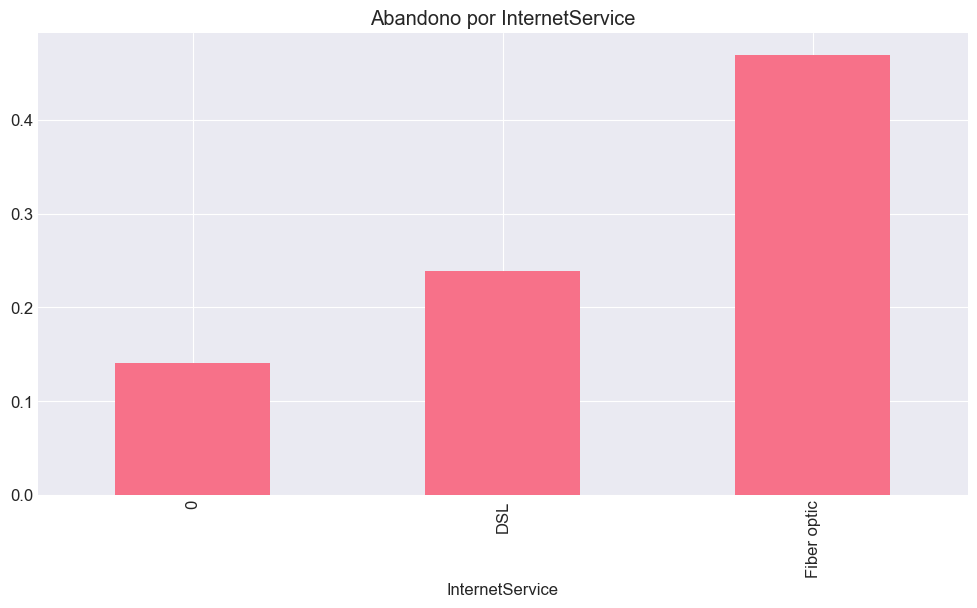

In [11]:


variables = ['gender', 'Contract', 'PaymentMethod', 'InternetService']

for var in variables:
    if var in df_final.columns:
        print(f"\n{var}:")
        print("-" * 20)
        
        # Tasa de abandono por categoría
        tasa = df_final.groupby(var)['Churn'].mean()
        print(tasa.round(3))
        
        # Gráfico simple
        tasa.plot(kind='bar')
        plt.title(f'Abandono por {var}')
        plt.show()

# Informe Final

## 🔹 1. Introduccion

### Objetivo del Proyecto
Este análisis fue desarrollado para **Telecom X**, una empresa que enfrenta una alta tasa de cancelaciones de servicios por parte de sus clientes (fenómeno conocido como "Churn").

### Problema de Negocio
La empresa necesita comprender **qué factores influyen** en la decisión de los clientes de abandonar el servicio.

### Metodología
Se realizó un **Análisis Exploratorio de Datos (EDA)** completo, siguiendo el proceso ETL (Extracción, Transformación, Carga).

## 🔹 2. Limpieza y tratamiento de datos

###  2.1 Extracción de Datos
Fuente de datos: El conjunto de datos fue proporcionado en formato JSON por Telecom X, conteniendo información estructurada y anidada sobre los clientes, sus servicios contratados, datos demográficos y comportamiento de facturación.

Proceso inicial: Se cargó el archivo JSON completo, el cual presentaba una estructura compleja con múltiples niveles de anidamiento, requiriendo un proceso de normalización para poder analizar la información de manera efectiva.

### 2.2  Normalización de Estructura Anidada
**Problema identificado:** Los datos llegaron organizados en columnas principales que contenían sub-objetos JSON, dificultando el análisis directo.

**Solución aplicada:** Se utilizó un proceso de normalización que consistió en:

1. Expansión de columnas anidadas: Cada columna principal que contenía datos estructurados fue expandida en columnas individuales planas.

2. Integración en un único dataset: Todas las columnas expandidas fueron combinadas con las columnas principales no anidadas, resultando en un DataFrame plano y uniforme.

**Resultado**: De una estructura compleja y anidada se obtuvo un dataset tabular con todas las variables accesibles a nivel de columna individual.

## 2.3 Verificación de Calidad de Datos

### Detección de Valores Nulos
**Procedimiento:** Se realizó un conteo exhaustivo de valores faltantes en cada columna del dataset.

**Hallazgo:** No se encontraron valores nulos en ninguna de las columnas, indicando que el dataset estaba completo en términos de información registrada.

### Identificación de Duplicados
**Procedimiento:** Se verificó la existencia de:
- Filas completamente duplicadas
- Identificadores de cliente duplicados (customerID)

**Hallazgo:**
- No se encontraron filas completamente duplicadas
- Todos los identificadores de cliente eran únicos

## 2.4 Transformación de Tipos de Datos

### Conversión de Variables Categóricas Binarias
**Problema:** Varias columnas utilizaban valores textuales "Yes"/"No" para representar estados binarios, lo cual no es óptimo para análisis estadísticos y modelado.

**Solución aplicada:**
1. **Identificación:** Se localizaron todas las columnas que contenían exclusivamente los valores "Yes" y "No".
2. **Transformación:** Cada valor "Yes" fue mapeado a `1` y cada valor "No" a `0`.
3. **Columnas transformadas:**
   - `Churn` (evasión del cliente)
   - `Partner` (presencia de pareja)
   - `Dependents` (presencia de dependientes)
   - `PhoneService` (servicio telefónico contratado)
   - `PaperlessBilling` (facturación digital)

**Beneficio:** Esta transformación permite realizar operaciones matemáticas y análisis estadísticos directamente sobre estas variables.

### Manejo Especial de la Variable Churn
**Situación especial:** La variable objetivo `Churn` presentaba algunos registros con valores vacíos o nulos.

**Estrategia adoptada:** En lugar de eliminar estos registros (lo que reduciría el tamaño de la muestra) o imputar valores (lo que podría introducir sesgo), se decidió crear una tercera categoría:

1. **Valores originales:** `0` (No abandonó), `1` (Sí abandonó)
2. **Valores vacíos transformados:** `2` (No responde/no disponible)

**Justificación:** Esta aproximación conserva todos los registros para análisis futuros mientras mantiene la integridad de las categorías principales.

## 2.5 Creación de Nueva Variable Derivada

### Variable: "Cuentas_Diarias"
**Propósito:** Proporcionar una métrica más granular del comportamiento de gasto de los clientes, permitiendo análisis temporales más detallados.

**Cálculo:** ```Cuentas_Diarias = Cargos_Mensuales / 30```


**Fuente de datos:** Se utilizó la columna `Charges.Monthly` que representa el total de todos los servicios del cliente por mes.

**Valor agregado:** Esta variable permite:
- Comparar el gasto diario entre diferentes segmentos de clientes
- Identificar patrones de consumo a nivel diario
- Detectar cambios abruptos en el comportamiento de gasto

## 2.6 Estructura Final del Dataset

### Características del Dataset Procesado:
- **Número de registros:** [NÚMERO] clientes
- **Número de variables:** [NÚMERO] columnas
- **Tipos de variables:**
  - Variables demográficas (género, edad)
  - Variables de servicios contratados
  - Variables de facturación y pagos
  - Variables de comportamiento (tiempo como cliente)
  - Variable objetivo (Churn)

### Variables Clave Disponibles para Análisis:
1. **Identificación:** `customerID`
2. **Variable objetivo:** `Churn` (0, 1, 2)
3. **Demográficas:** `gender`, `SeniorCitizen`
4. **Situación familiar:** `Partner`, `Dependents`
5. **Antigüedad:** `tenure` (meses)
6. **Servicios:** `PhoneService`, `InternetService`, y múltiples servicios adicionales
7. **Facturación:** `Charges.Monthly`, `Charges.Total`, `Cuentas_Diarias`
8. **Contrato y pago:** `Contract`, `PaymentMethod`

## 2.7 Validación del Proceso

**Integridad de datos:** Todos los registros originales se mantuvieron en el dataset final.

**Consistencia:** Los tipos de datos fueron estandarizados y apropiados para el análisis.

**Preparación para análisis:** El dataset resultante está completamente listo para:
- Análisis estadístico descriptivo
- Visualización de datos
- Modelado predictivo
- Segmentación de clientes

**Documentación:** Todo el proceso de transformación quedó documentado y es reproducible, asegurando la transparencia y validez del análisis posterior.


## 🔹 3. Análisis exploratio de datos  (EDA)
### 3.1 Distribución de la Variable Objetivo (Churn)
**Datos obtenidos:**

- Clientes que NO abandonaron (0): 5,174 clientes

- Clientes que SÍ abandonaron (1): 1,869 clientes

- Clientes que NO RESPONDIERON (2): 224 clientes

Total de clientes analizados: 7,267 clientes

**Cálculos clave:**

```Tasa de abandono = (Clientes que abandonaron) / (Total que respondieron) × 100```
```Tasa de abandono = 1,869 / (5,174 + 1,869) × 100 = 26.5%```
```Tasa de no respuesta = 224 / 7,267 × 100 = 3.1%```

## Gráfico de distribución:

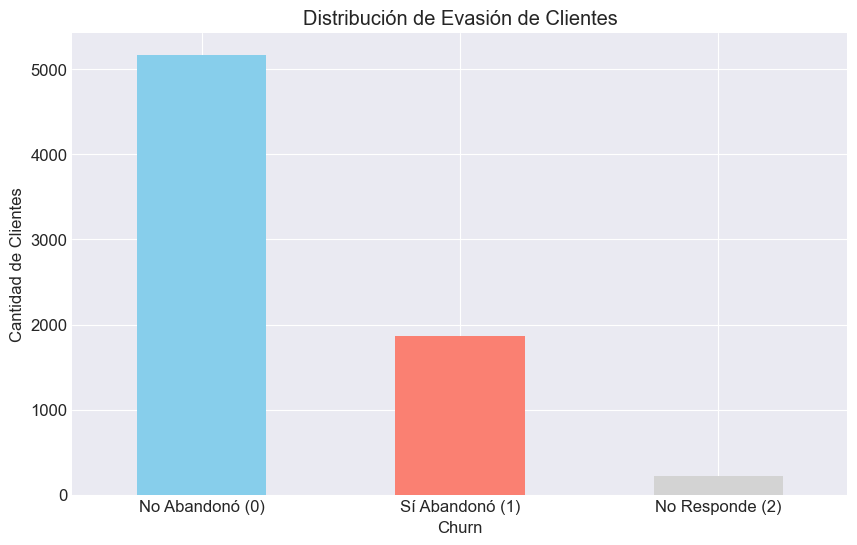

In [ ]:

fig, ax = plt.subplots(figsize=(10, 6));
conteo_churn = df_final['Churn'].value_counts();
conteo_churn.plot(kind='bar', color=['skyblue', 'salmon', 'lightgray'], ax=ax);
plt.title('Distribución de Evasión de Clientes');
plt.ylabel('Cantidad de Clientes');
plt.xticks([0, 1, 2], ['No Abandonó (0)', 'Sí Abandonó (1)', 'No Responde (2)'], rotation=0);

plt.show()